## Chapter 6 - Problem 11
***

**11.** We will now try to predict per capita crime rate in the Boston data
set.

**A.** Try out some of the regression methods explored in this chapter,
such as best subset selection, the lasso, ridge regression, and
PCR. Present and discuss results for the approaches that you
consider.

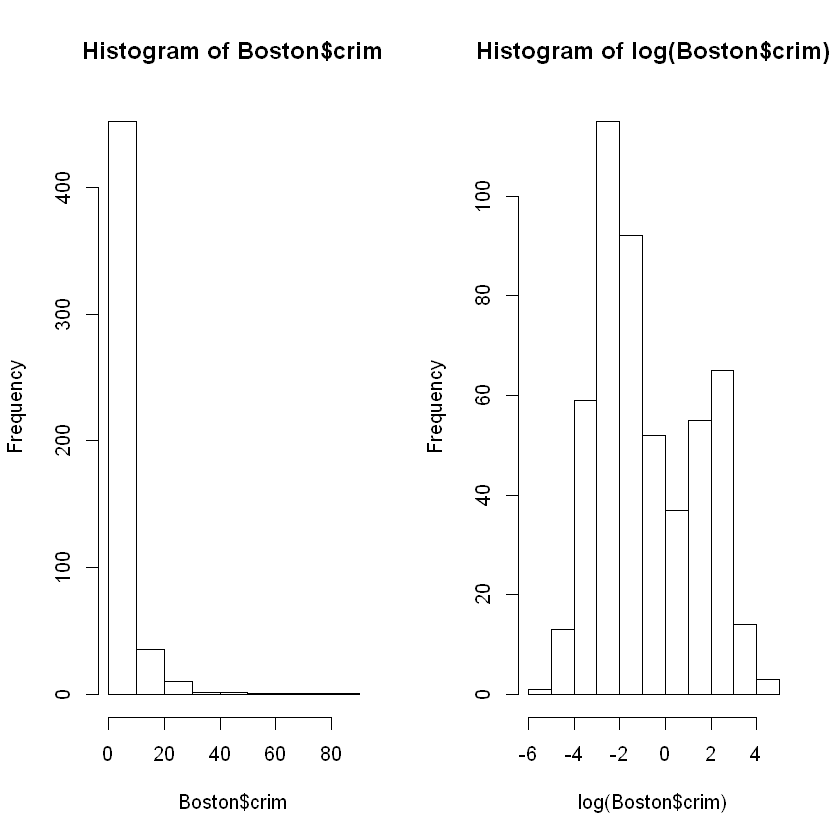

In [14]:
library(MASS)
par(mfrow = c(1,2))
hist(Boston$crim)
hist(log(Boston$crim))

Crime does not distribute normally according to the histogram, I will use a logarithmic transformation to improve the model.

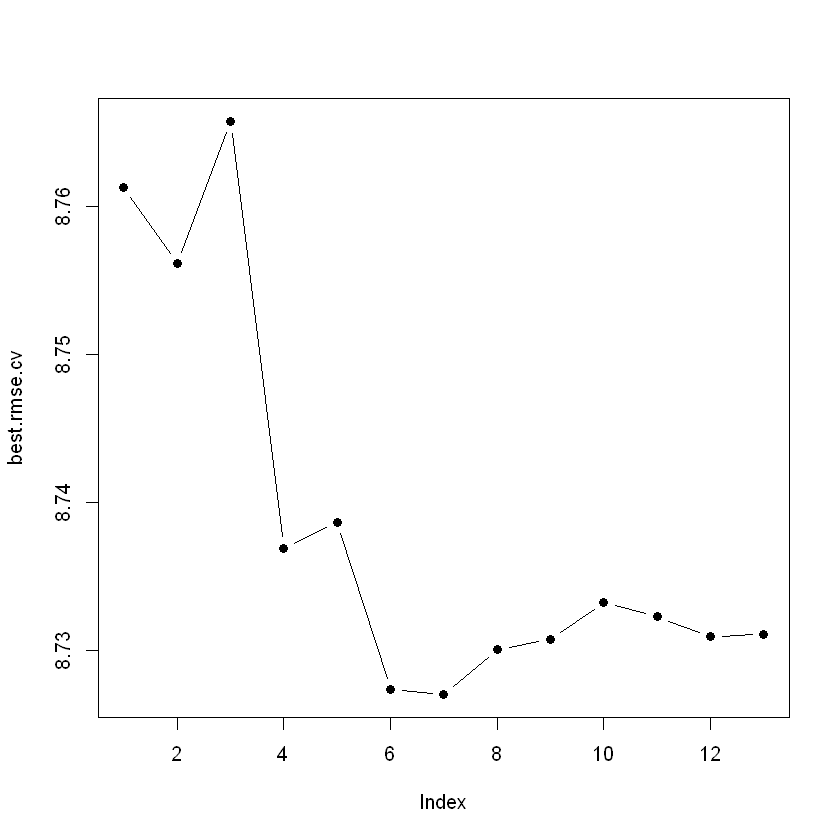

In [15]:
library(leaps)
Boston.mod <- Boston
Boston.mod$crim <- log(Boston.mod$crim)

predict.regsubsets =function (object ,newdata ,id ,...){
    form <-as.formula (object$call[[2]])
    mat <- model.matrix(form,newdata)
    coefi <- coef(object,id=id)
    xvars <- names (coefi)
    mat[,xvars]%*% coefi
}

## 10 fold Cross validation
k = 10
p = 13
folds = sample(rep(1:k, length = nrow(Boston.mod)))
cv.errors.best = matrix(NA, k, p)

for (i in 1:k) {
    best.fit = regsubsets(crim ~ ., data = Boston.mod[folds != i, ], nvmax = 13)
    for (j in 1:p) {
        pred = predict(best.fit, Boston[folds == i,], id = j)
        cv.errors.best[i, j] = mean((Boston$crim[folds == i] - pred)^2)
    }
}

best.rmse.cv = sqrt(apply(cv.errors.best, 2, mean))
plot(best.rmse.cv, pch = 19, type = "b")

In [16]:
which.min(best.rmse.cv)
best.rmse = min(best.rmse.cv)
best.rmse
best.fit = regsubsets(crim ~ ., data = Boston.mod, nvmax = 13)
coef(best.fit,which.min(best.rmse.cv))


[1] 7

[1] 8.727022

(Intercept)           zn          nox          age          rad      ptratio 
-3.903156863 -0.012595306  4.334035075  0.006632580  0.143506161 -0.044242723 
       black        lstat 
-0.001416038  0.028304687

In [17]:
library(glmnet)

x <- model.matrix(crim~.-1,data = Boston.mod) #Eliminates intercept
y <- Boston.mod$crim

param <- seq(5,-2,length = 100)
lambdas <- 10^param
ridge.cv <- cv.glmnet(x,y,alpha = 0,lambda = lambdas)
coef(ridge.cv)

14 x 1 sparse Matrix of class "dgCMatrix"
                       1
(Intercept) -4.051004766
zn          -0.008832022
indus        0.017327978
chas         0.043479326
nox          3.152516926
rm          -0.008649005
age          0.006014085
dis         -0.064983674
rad          0.084563133
tax          0.002030474
ptratio     -0.005735834
black       -0.001785148
lstat        0.027102954
medv         0.003462221

In [18]:
loc <- which(ridge.cv$lambda == ridge.cv$lambda.1se)
ridge.rmse <- sqrt(ridge.cv$cvm[loc])
ridge.rmse

[1] 0.8132152

Due to the minimum near 0 for the ridge regression, a least square model is preferred over the ridge regression.

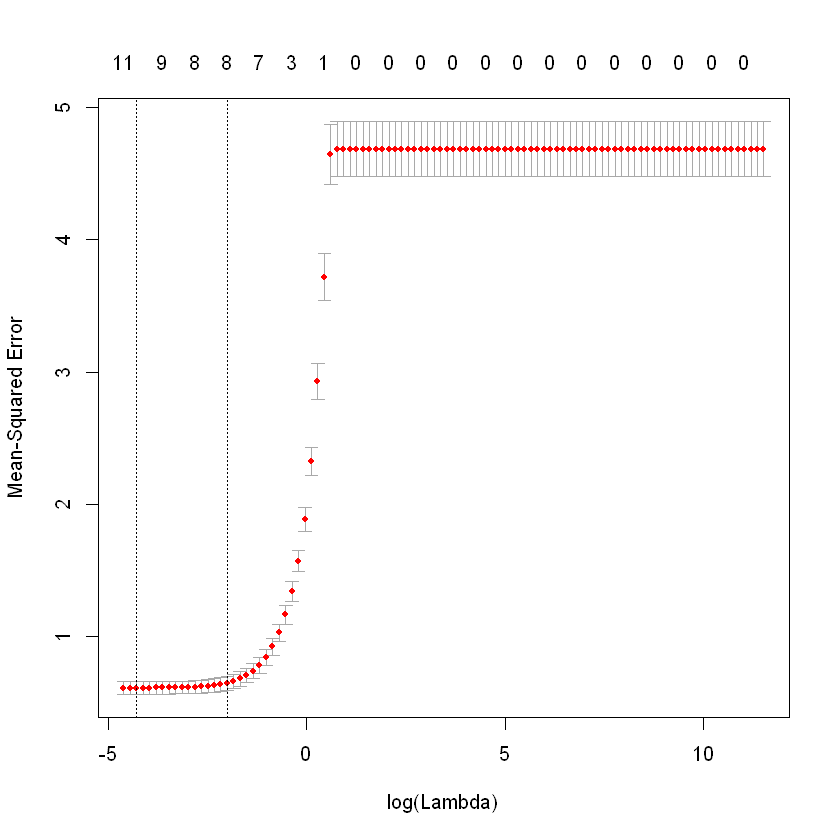

In [19]:
lasso.cv <- cv.glmnet(x,y,alpha = 1,lambda = lambdas,type.measure = "mse")
plot(lasso.cv)

In [20]:
coef(lasso.cv)

14 x 1 sparse Matrix of class "dgCMatrix"
                        1
(Intercept) -4.7112979186
zn          -0.0064244567
indus        0.0134937494
chas         .           
nox          4.2502909020
rm           .           
age          0.0046010031
dis         -0.0274976117
rad          0.1300520912
tax          .           
ptratio      .           
black       -0.0005375367
lstat        0.0185426143
medv         .           

In [21]:
loc <- which(lasso.cv$lambda == lasso.cv$lambda.1se)
lasso.rmse <- sqrt(lasso.cv$cvm[loc])
lasso.rmse

[1] 0.8047857

In [22]:
require(pls)
pls.fit <- plsr(crim ~ ., data = Boston.mod, scale = TRUE, validation = "CV")
summary(pls.fit)

Data: 	X dimension: 506 13 
	Y dimension: 506 1
Fit method: kernelpls
Number of components considered: 13

VALIDATION: RMSEP
Cross-validated using 10 random segments.
       (Intercept)  1 comps  2 comps  3 comps  4 comps  5 comps  6 comps
CV           2.164   0.9947   0.8506   0.8190   0.7999   0.7947   0.7914
adjCV        2.164   0.9944   0.8499   0.8181   0.7987   0.7935   0.7898
       7 comps  8 comps  9 comps  10 comps  11 comps  12 comps  13 comps
CV      0.7895   0.7882   0.7877    0.7878    0.7880    0.7880    0.7880
adjCV   0.7881   0.7868   0.7863    0.7865    0.7866    0.7866    0.7866

TRAINING: % variance explained
      1 comps  2 comps  3 comps  4 comps  5 comps  6 comps  7 comps  8 comps
X       47.52    58.15    66.00    72.08    76.37    78.54    83.84    85.99
crim    79.09    85.03    86.32    87.05    87.26    87.47    87.51    87.53
      9 comps  10 comps  11 comps  12 comps  13 comps
X       88.22     92.39     96.47     98.24    100.00
crim    87.54     87.54 

**B.** Propose a model (or set of models) that seem to perform well on
this data set, and justify your answer. Make sure that you are
evaluating model performance using validation set error, crossvalidation,
or some other reasonable alternative, as opposed to
using training error.

* Although Partial Squares has the least RMSE of all models, Lasso has a simpler model with a low RMSE. Hence this is the model i would choose

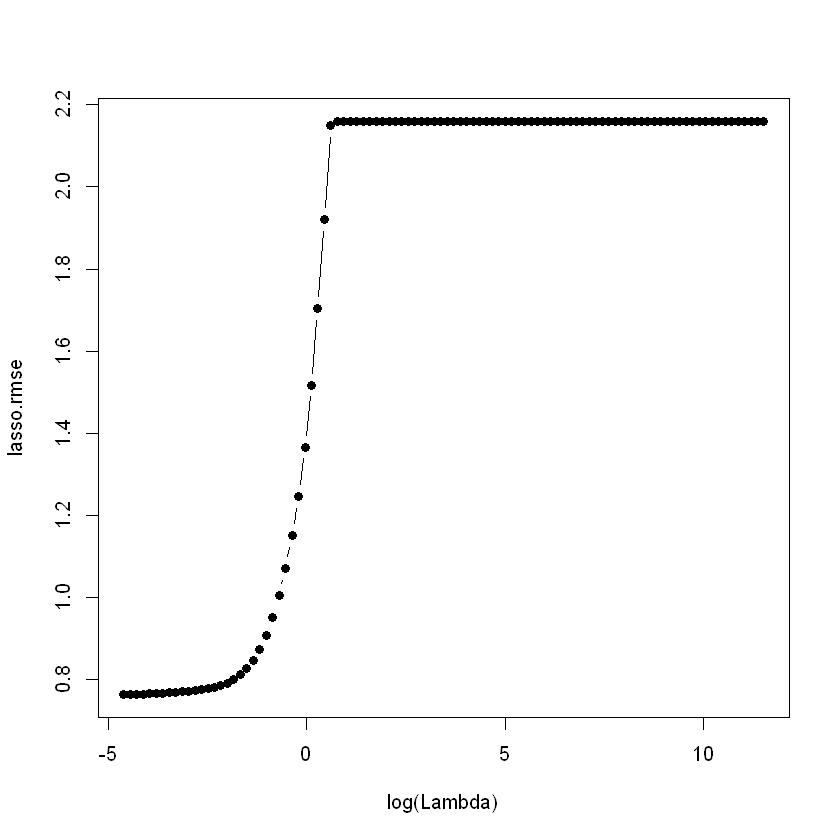

In [23]:
lasso.fit <- glmnet(x,y,alpha = 1,lambda = lambdas)
lasso.pred <- predict(lasso.fit,newx = x)
lasso.rmse <- sqrt(apply((y-lasso.pred)^2,2,mean)) 
plot(log(lasso.fit$lambda),lasso.rmse,type = "b",xlab = "log(Lambda)",pch = 19)

In [ ]:
**C.**Does your chosen model involve all of the features in the data
set? Why or why not?

No, because not all predictors are significant. several variables like tax or ptratio have been discarded by the regression method